In [7]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' #added by kuang
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import stellargraph as sg
from stellargraph.layer import GCN_LSTM

def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

dataset = sg.datasets.METR_LA()
speed_data, sensor_dist_adj = dataset.load()
num_nodes, time_len = speed_data.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)
print(speed_data.head())

def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled


2023-05-23 11:51:31.643808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 11:51:31.920345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/netcdf/netcdf4_gcc/lib:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64_lin:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/mpi/intel64/libfabric/lib:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/mpi/intel64/lib/release:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/mpi/intel64/lib:/opt/intel_f/compilers_and_libraries_2020.

No. of sensors: 207 
No of timesteps: 2016
          0          1      2          3          4          5       6     \
773869  64.375  62.666667  64.00  61.777778  59.555556  57.333333  66.500   
767541  67.625  68.555556  63.75  65.500000  67.250000  69.000000  63.875   
767542  67.125  65.444444  60.00  62.555556  65.111111  67.666667  67.875   
717447  61.500  62.444444  59.00  59.888889  60.777778  61.666667  62.375   
717446  66.875  64.444444  66.50  66.777778  67.055556  67.333333  64.375   

          7       8       9     ...    2006       2007    2008    2009  \
773869  63.625  68.750  63.500  ...  64.625  65.444444  63.125  62.875   
767541  67.250  65.250  61.500  ...  67.125  66.555556  68.125  67.125   
767542  63.250  63.500  62.500  ...  66.500  66.222222  67.625  68.625   
717447  60.500  63.000  58.125  ...  55.625  61.000000  58.750  60.625   
717446  57.375  65.125  66.625  ...  65.625  58.000000  66.625  67.125   

          2010       2011    2012    2013       2

2023-05-23 11:51:39.814186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/netcdf/netcdf4_gcc/lib:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64_lin:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/mpi/intel64/libfabric/lib:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/mpi/intel64/lib/release:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/mpi/intel64/lib:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64_lin:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/mkl/lib/intel64_lin:/opt/netcdf/netcdf4_gcc/lib:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64_lin:/opt/intel_f/compilers_and_libraries_2020.0.166/linux/mpi/intel64/libfabr

In [28]:
sensor_dist_adj.shape

(207, 207)

In [9]:
train_rate = 0.8
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

train_scaled, test_scaled = scale_data(train_data, test_data)


Train data:  (207, 1612)
Test data:  (207, 404)


(1591, 207, 10)
(1591, 207)
(383, 207, 10)
(383, 207)


/home/kuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  app.launch_new_instance()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 207, 10)]         0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 207, 10, 1)       0         
                                                                 
 reshape (Reshape)           (None, 207, 10)           0         
                                                                 
 fixed_adjacency_graph_convo  (None, 207, 16)          43216     
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 fixed_adjacency_graph_convo  (None, 207, 10)          43216     
 lution_1 (FixedAdjacencyGra                                     
 phConvolution)                                              

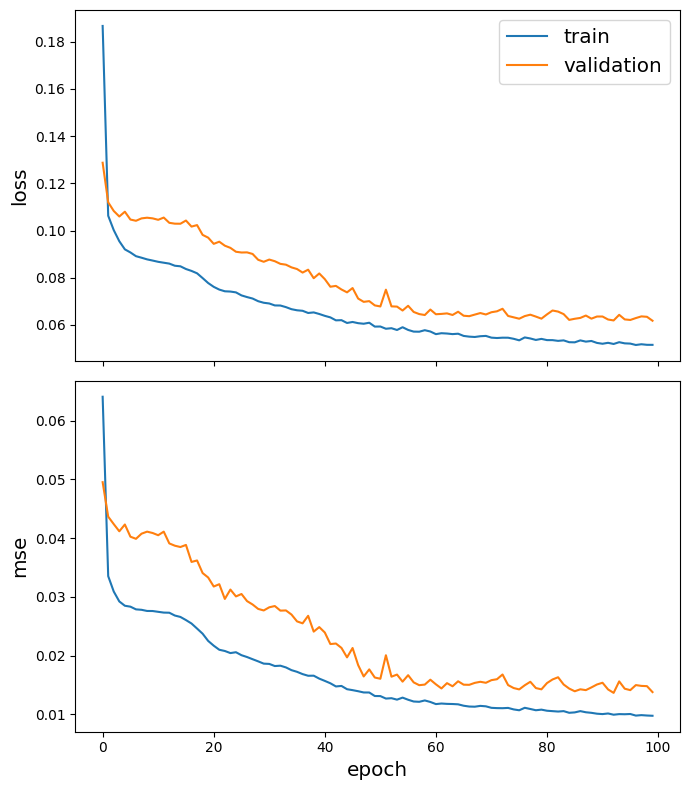

In [4]:
seq_len = 10
pre_len = 12
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
from stellargraph.layer import GCN_LSTM
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],)
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer="adam", loss="mae", metrics=["mse"])
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)
print(model.summary())
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],)
sg.utils.plot_history(history)


In [5]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

12/12 [==============================] - 0s 11ms/step


Total (ave) MAE for NN: 3.939766544698969
Total (ave) MAE for naive prediction: 5.619645381284217
Total (ave) MASE for per-segment NN/naive MAE: 0.6980921888883611
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


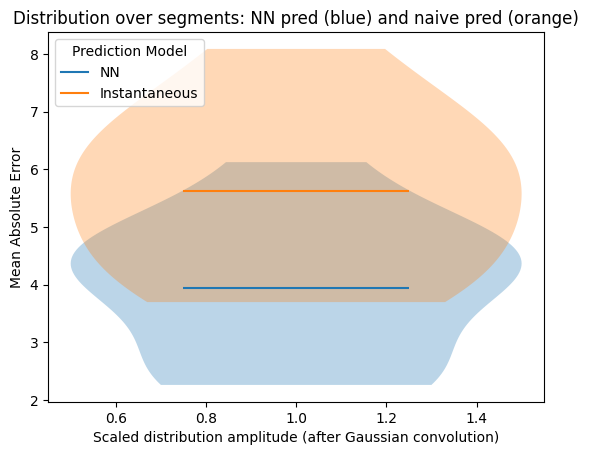

In [6]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * (max_speed-min_speed))+min_speed
test_rescref = np.array(testY * (max_speed-min_speed))+min_speed
## Rescale model predicted values
train_rescpred = np.array((ythat) * (max_speed-min_speed))+min_speed
test_rescpred = np.array((yhat) * (max_speed-min_speed))+min_speed
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

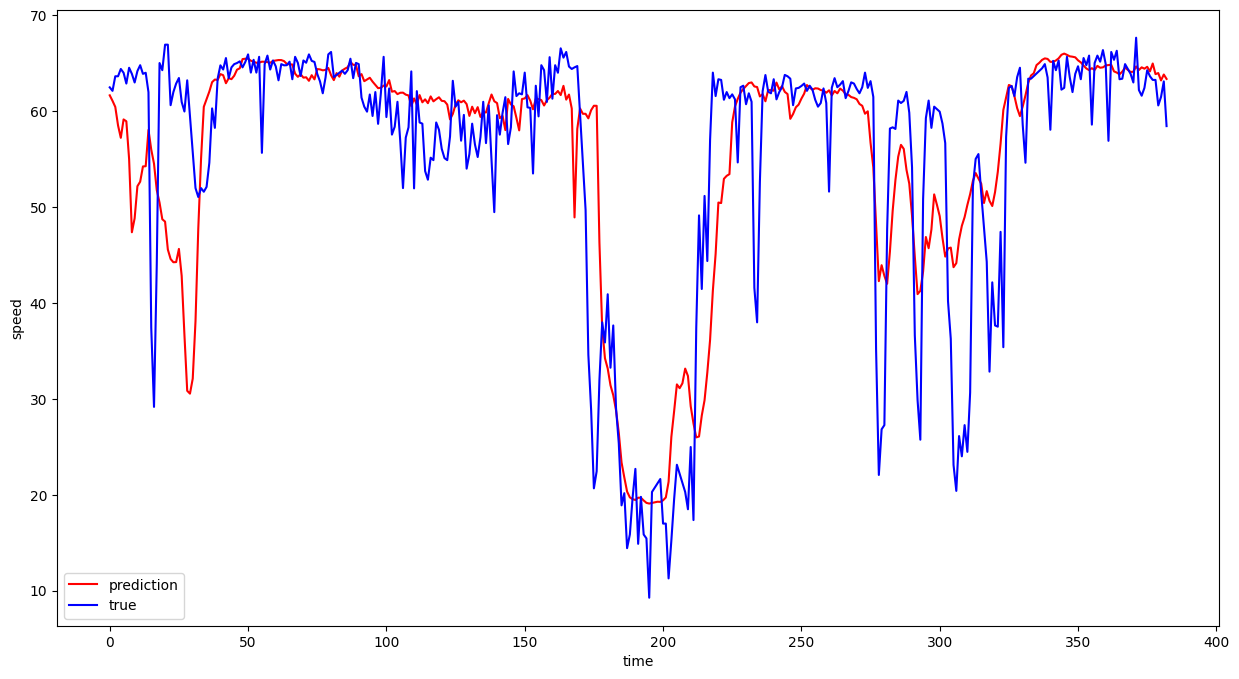

In [7]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 100]
a_true = test_rescref[:, 100]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

In [26]:
import netCDF4
from pyproj import Proj
import numpy as np
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd


nc = netCDF4.Dataset("2019.nc",'r')
pnyc = Proj(proj='lcc', datum='NAD83', lat_1=nc.P_ALP, lat_2=nc.P_BET,lat_0=nc.YCENT, lon_0=nc.XCENT, x_0=0, y_0=0.0)
V=[list(filter(lambda x:nc[x].ndim==j, [i for i in nc.variables])) for j in [1,2,3,4]]
nt,nlay,nrow,ncol=nc.variables[V[3][0]].shape
NM=nrow*ncol
x1d=[nc.XORIG+nc.XCELL*(i+0.5) for i in range(ncol)]
y1d=[nc.YORIG+nc.YCELL*(i+0.5) for i in range(nrow)]
X,Y=np.meshgrid(x1d,y1d)
X,Y=X.flatten(),Y.flatten()
lons, lats= pnyc(X,Y, inverse=True)
pnts=[Point(lon,lat) for lon,lat in zip(lons,lats)]
dfNod=pd.DataFrame({'geometry':pnts,'name':[str(i) for i in range(NM)]})
root='/nas2/cmaqruns/2022fcst/fusion/Voronoi/'
boundary=gpd.read_file(root+'boundary_shape.shp')
boundary_shape = boundary.geometry[0]

name_inside=dfNod.loc[dfNod.geometry.map(lambda p:p.within(boundary_shape)),'name']
for t in range(nt):
    dfNod[str(t)]=nc['NO2'][t,0,:,:].flatten()
dfNod['X']=X
dfNod['Y']=Y
print(dfNod.head())    

/home/kuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


                                        geometry name         0         1  \
0  POINT (119.29562834511216 21.789882278968808)    0  1.517539  1.519019   
1  POINT (119.32560108935127 21.790026335070614)    1  1.585425  1.601139   
2   POINT (119.3555739011114 21.790164128037024)    2  1.649157  1.644482   
3   POINT (119.3855467773919 21.790295657844926)    3  1.705202  1.653017   
4  POINT (119.41551971519209 21.790420924472205)    4  1.765325  1.693072   

          2         3         4         5         6         7  ...      8752  \
0  1.433870  1.023531  0.741587  0.684578  0.708815  0.744206  ...  1.603465   
1  1.519433  1.153242  0.820746  0.685812  0.745295  0.782119  ...  1.667582   
2  1.578399  1.258174  0.951524  0.761962  0.781636  0.803096  ...  1.714008   
3  1.580557  1.303726  1.071391  0.891530  0.815769  0.814868  ...  1.675010   
4  1.632309  1.323370  1.134811  1.002506  0.848980  0.830899  ...  1.388731   

       8753      8754      8755      8756      8757     

/home/kuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/home/kuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [27]:
s=set(name_inside)
n=len(s)
dfNod2=dfNod.loc[dfNod.name.map(lambda x:x in s)].reset_index(drop=True)

In [29]:
dfNod2.head()

,geometry,name,0,1,2,3,4,5,6,7,...,8752,8753,8754,8755,8756,8757,8758,8759,X,Y
0,POINT (120.85499944832115 21.901044724151117),420,0.677471,0.459883,0.426217,0.377481,0.307405,0.262025,0.243741,0.282244,...,0.414413,0.432127,0.450809,0.460715,0.479719,0.518139,0.512078,0.525206,85500.0,-331500.0
1,POINT (120.73516676523461 21.92970541028734),508,1.304548,1.119042,0.845644,0.632503,0.505557,0.399560,0.340640,0.407118,...,0.513870,0.537055,0.547205,0.576908,0.652880,0.746254,0.844142,0.810558,73500.0,-328500.0
2,POINT (120.73533147367094 21.957702225639682),600,1.367202,1.183671,0.881260,0.642891,0.515621,0.393440,0.322829,0.365855,...,0.506137,0.525275,0.546105,0.576469,0.661151,0.785124,0.925633,0.888884,73500.0,-325500.0
3,POINT (120.79535717535003 21.95738231971305),602,1.110809,0.856888,0.648739,0.520782,0.409563,0.307899,0.259140,0.294586,...,0.474449,0.509128,0.510757,0.531093,0.587140,0.615679,0.620544,0.605079,79500.0,-325500.0
4,POINT (120.82536990792939 21.957212958120095),603,0.999884,0.709552,0.554311,0.442981,0.357197,0.294803,0.253879,0.296948,...,0.440190,0.487237,0.485199,0.516619,0.559509,0.565741,0.563126,0.570004,82500.0,-325500.0


In [45]:
d=np.zeros(shape=(n,n))
X1=np.zeros(shape=(n,n))
Y1=np.zeros(shape=(n,n))
X2=np.zeros(shape=(n,n))
Y2=np.zeros(shape=(n,n))
X,Y=np.array(dfNod2.X),np.array(dfNod2.Y)
X1[:,:],X2[:,:]=X[:,None],X[None,:]
Y1[:,:],Y2[:,:]=Y[:,None],Y[None,:]
d[:,:]=np.sqrt((X1-X2)**2+(Y1-Y2)**2) #dfNod2.geometry[j].distance(dfNod2.geometry[i])        
#for j in range(n):
#    for i in range(0,j):
#        d[j,i]=d[i,j]
d=1/d*1000.
for j in range(n):
    d[j,j]=1.
dmax=d.max()   
for j in range(n):
    d[j,j]=dmax
d=np.sqrt(np.sqrt(d/dmax))

/home/kuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [46]:
d[:5,:5]#==d[-5:,-5:] #d[NM//2-5:NM//2+5,NM//2-5:NM//2+5]

array([[1.        , 0.53322877, 0.52250558, 0.58591341, 0.62136736],
       [0.53322877, 1.        , 0.75983569, 0.62136736, 0.56979638],
       [0.52250558, 0.75983569, 1.        , 0.6389431 , 0.57735027],
       [0.58591341, 0.62136736, 0.6389431 , 1.        , 0.75983569],
       [0.62136736, 0.56979638, 0.57735027, 0.75983569, 1.        ]])

In [30]:
from scipy.io import FortranFile
n=NM
fname='pnt_InvDis'+str(n)+'x'+str(n)+'.bin'
with FortranFile(fname, 'w') as f:
    f.write_record(d)

In [7]:
from scipy.io import FortranFile
n=3739
fname='pnt_Dis'+str(n)+'x'+str(n)+'.bin'
with FortranFile(fname, 'r') as f:
    d=f.read_record(dtype=np.float64)
d=d.reshape(n,n)
d=1/d
for j in range(n):
    d[j,j]=1.
dmax=d.max()
for j in range(n):
    d[j,j]=dmax
d=d/d.max()

/home/kuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [8]:
d[:5,:5]

array([[1.        , 0.22722786, 0.21145553, 0.34124972, 0.44087338],
       [0.22722786, 1.        , 1.        , 0.42260873, 0.29688302],
       [0.21145553, 1.        , 1.        , 0.46641524, 0.31094373],
       [0.34124972, 0.42260873, 0.46641524, 1.        , 0.93283256],
       [0.44087338, 0.29688302, 0.31094373, 0.93283256, 1.        ]])

In [47]:
for i in ['geometry','name','X','Y']:
    if i in dfNod2.columns: del dfNod2[i]
train_rate = 0.5
train_data, test_data = train_test_split(dfNod2, train_rate)
train_scaled, test_scaled = scale_data(train_data, test_data)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (3739, 4380)
Test data:  (3739, 4380)


The function below returns the above transformed timeseries data for the model to train on. 
The parameter seq_len is the size of the past window of information. 
The pre_len is how far in the future does the model need to learn to predict.
Each training observation are 10 historical speeds (seq_len).
Each training prediction is the speed 60 minutes later (pre_len).

In [48]:
seq_len = 72
pre_len = 24
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(4285, 3739, 72)
(4285, 3739)
(4285, 3739, 72)
(4285, 3739)


/home/kuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3739, 72)]        0         
                                                                 
 tf.expand_dims_4 (TFOpLambd  (None, 3739, 72, 1)      0         
 a)                                                              
                                                                 
 reshape_12 (Reshape)        (None, 3739, 72)          0         
                                                                 
 fixed_adjacency_graph_convo  (None, 3739, 16)         13985012  
 lution_8 (FixedAdjacencyGra                                     
 phConvolution)                                                  
                                                                 
 fixed_adjacency_graph_convo  (None, 3739, 72)         13985012  
 lution_9 (FixedAdjacencyGra                               

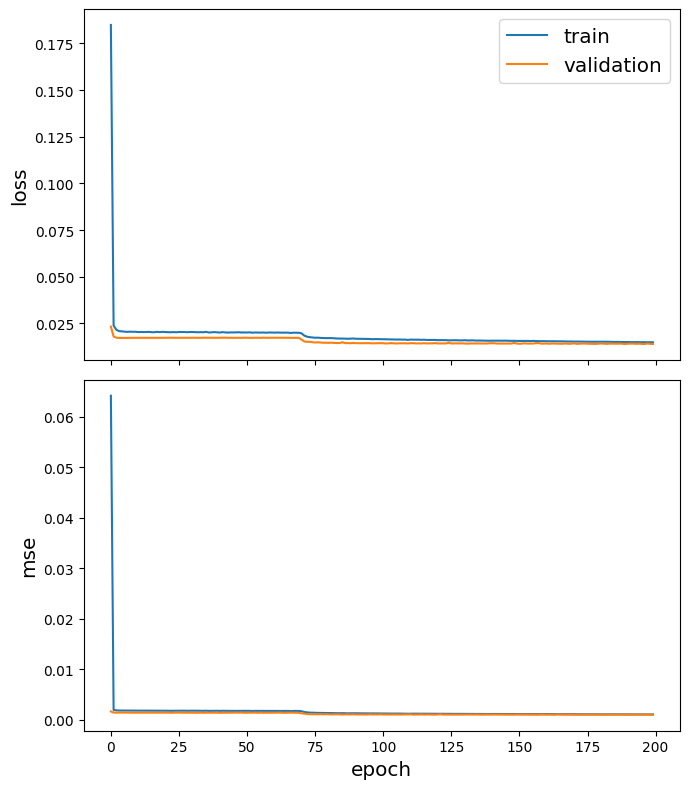

In [53]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=d,
    gc_layer_sizes=[16, 72],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[20, 72],
    lstm_activations=["tanh", "tanh"],)
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer="adam", loss="mae", metrics=["mse"])
history = model.fit(
    trainX,
    trainY,
    epochs=200,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)
print(model.summary())
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],)
sg.utils.plot_history(history)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3739, 72)]        0         
                                                                 
 tf.expand_dims_4 (TFOpLambd  (None, 3739, 72, 1)      0         
 a)                                                              
                                                                 
 reshape_12 (Reshape)        (None, 3739, 72)          0         
                                                                 
 fixed_adjacency_graph_convo  (None, 3739, 16)         13985012  
 lution_8 (FixedAdjacencyGra                                     
 phConvolution)                                                  
                                                                 
 fixed_adjacency_graph_convo  (None, 3739, 72)         13985012  
 lution_9 (FixedAdjacencyGra                               

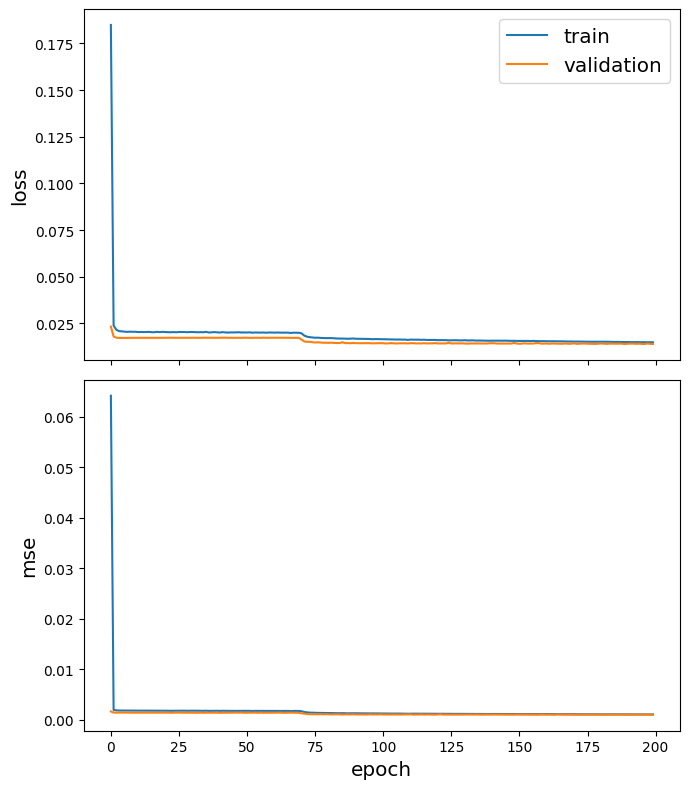

In [54]:
print(model.summary())
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],)
sg.utils.plot_history(history)

134/134 [==============================] - 16s 120ms/step
Total (ave) MAE for NN: 0.27388382
Total (ave) MAE for naive prediction: 0.42016855
Total (ave) MASE for per-segment NN/naive MAE: 0.65035915
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


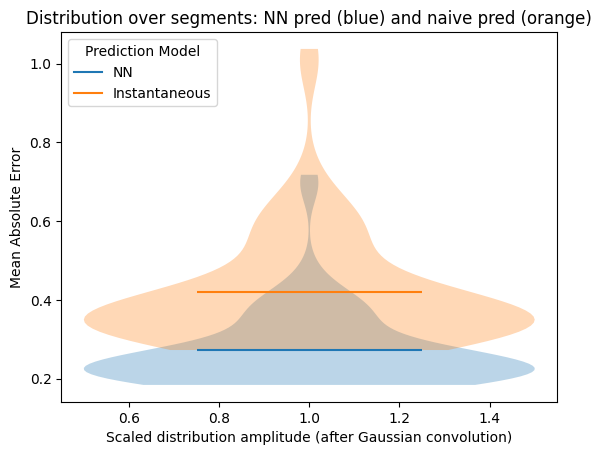

In [55]:
ythat = model.predict(trainX)
yhat = model.predict(testX)
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX)[
    :, :, -5
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

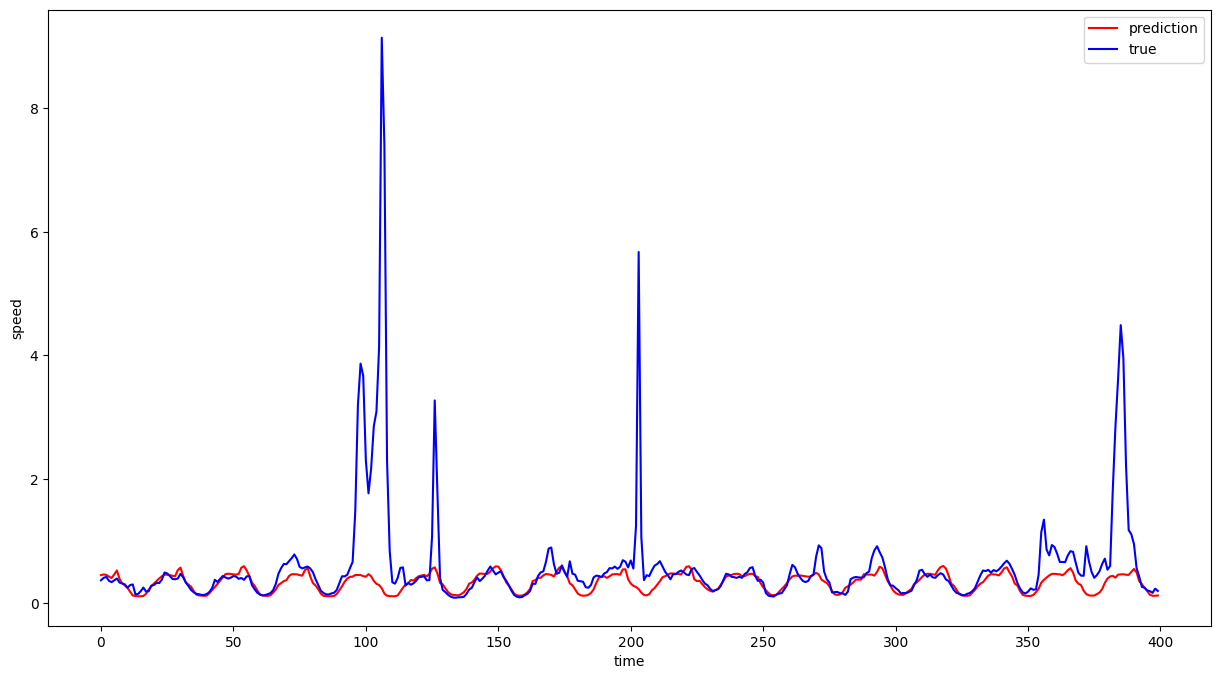

In [60]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[100:500, 35]
a_true = test_rescref[100:500, 35]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

In [20]:
nc = netCDF4.Dataset("2019.nc",'r')
V=[list(filter(lambda x:nc[x].ndim==j, [i for i in nc.variables])) for j in [1,2,3,4]]
nt,nlay,nrow,ncol=nc.variables[V[3][0]].shape
dfNod=pd.DataFrame({'geometry':pnts,'name':[str(i) for i in range(NM)]})
for t in range(nt):
    dfNod[str(t)]=nc['NO2'][t,0,:,:].flatten()

/home/kuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [116]:
dfNod2.shape[1]

8762